**MLP : метод обратного распространения ошибки**

три обрабатывающих слоя

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

##  загружаем данные 

In [2]:
# # загружаем даные
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt')
# ]

In [3]:
data = [
    np.loadtxt('../data/1998_2/points_b.txt'),
    np.loadtxt('../data/1998_2/points_r.txt')
]

In [4]:
# data = [
#     np.loadtxt('../data/6402_2/points_1.txt'),
#     np.loadtxt('../data/6402_2/points_2.txt') 
# ]

In [5]:
# data = [ np.vstack([
#             np.loadtxt('../data/399_4/points_b.txt'),
#             np.loadtxt('../data/399_4/points_g.txt'),
#             np.loadtxt('../data/399_4/points_r.txt')
#         ]),
#         np.loadtxt('../data/399_4/points_y.txt') 
# ]

In [6]:
# собираем вместе
X = np.vstack(data)

# метки классов
# [0,1] для выходной активации softmax
y = [ [i]*data[i].shape[0] for i in range(len(data)) ]
y = np.asarray(sum(y,[])).reshape(X.shape[0],1)
y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y)

In [7]:
X.shape, y.shape

((1998, 2), (1998, 2))

In [8]:
%xdel data

In [9]:
# нормируем данные
X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

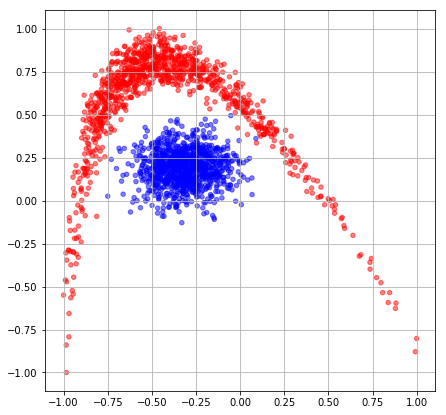

In [10]:
plt.figure(figsize=(7,7))
plt.scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j[0]>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
plt.grid()
plt.show()

##  ф-ции слоёв

In [11]:
# ф-ции активации скрытых слоёв и её производная 
def relu(z): return np.maximum( np.zeros(z.shape), z )
def relu_drv(z): return (z>0.0).astype(float)

# def lrelu(z): return np.log(1.0+np.exp(z))
# def lrelu_drv(z): return np.exp(z)/(np.exp(z)+1.0);

# def sigm(z): return np.tanh(z)
# def sigm_drv(z): return 1.0/(np.cosh(z)**2)

In [12]:
# ф-ция активации выходного слоя и её производная 
def softmax(z): 
    e = np.exp(z)
    return e/e.sum()

def softmax_drv(z): return 1.0 

In [13]:
# функция потери

# средняя кросс-энтропия
# def cross_entr(o,y):
#     s = (o*y).sum(axis=1)
#     return ( -np.log( s )).sum()/o.shape[0]

#  кросс-энтропия
def cross_entr(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

# # средняя квадратичная ошибка
# def msqe(o,y):
#     e = (o-y).flatten() # ошибки примеров
#     return np.asscalar( e.T.dot(e) / o.shape[0] ) 


##  параметры сети

In [14]:
# размер скрытого слоя
s_layer1 = 5
s_layer2 = 3

In [15]:
act1 = relu
act1_drv = relu_drv

act2 = relu
act2_drv = relu_drv

act3 = softmax
act3_drv = softmax_drv

loss = cross_entr 

---

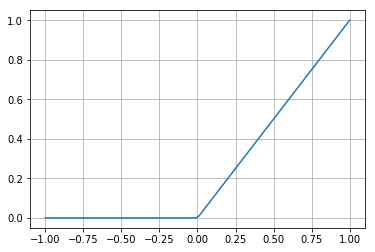

In [16]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1(jj) )
plt.grid()
plt.show()

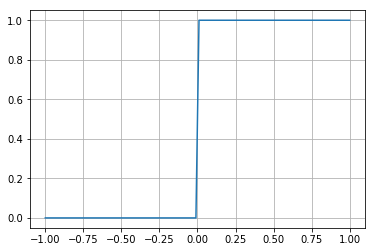

In [17]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1_drv(jj) )
plt.grid()
plt.show()

##  метод обратного распространения 

In [18]:
# выход
def run(x): 
    return act3( act2( act1( x.dot(W1) + S1 ).dot(W2) + S2 ).dot(W3) + S3 ) # выход сети

In [19]:
# прямой проход
def forward(x):
    L = [ x.dot(W1) + S1 ] # состояние (не активированное) скрытого слоя
    L.append( act1(L[-1]).dot(W2) + S2 ) # состояние (не активированное) скрытого слоя
    L.append( act2(L[-1]).dot(W3) + S3 ) # состояние (не активированное) выходного слоя
    return L

In [20]:
# обратный проход
def backward(L,y):
    O = act3(L[2]) # выход сети
    E = [ (O-y)*act3_drv(L[2]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W3.T)*act2_drv(L[1]) ) # ошибка скрытого слоя
    E.insert(0, E[0].dot(W2.T)*act1_drv(L[0]) ) # ошибка скрытого слоя
    return E

In [21]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход

In [22]:
# градиент
def grad(L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O1 = act1(L[0]) # выход скрытого слоя
    GW.append( O1.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    O2 = act2(L[1]) # выход скрытого слоя
    GW.append( O2.T.dot(E[2]) ) # градиент по весам выходного слоя
    GS.append( E[2].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS

In [23]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход
# G = grad(L,E)

In [24]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), 
                            gw[1].flatten(), 
                            gw[2].flatten(), 
                            
                            gs[0], 
                            gs[1], 
                            gs[2], 
                          ]) ).max()
    
    if (mw != 0):
        gw[0], gw[1], gw[2] = gw[0]/mw, gw[1]/mw, gw[2]/mw, 
        gs[0], gs[1], gs[2] = gs[0]/mw, gs[1]/mw, gs[2]/mw
            
    return gw,gs

## обучение сети

In [25]:
# инициализация весов и сдвигов
W1 = np.random.normal( loc=0.0, scale=0.01, size = [X.shape[1], s_layer1] )  
S1 = np.zeros(s_layer1)

W2 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer1, s_layer2 ] ) 
S2 = np.zeros(s_layer2)

W3 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer2, y.shape[1] ] ) 
S3 = np.zeros(y.shape[1])

In [26]:
# метод градиентного спуска

# sa = 0.95 # изменение скорости обучения

a = 0.01 # скорость обучения
m = 0.1  # параметр момента
r = 0.001  # параметр регуляризации

# максимальное число циклов обучения
MAX_ITER = 1800

MIN_ERROR = 0.05 # порог минимальной ошибки

err =[1e7,1e6,1e5] 

dW1,dW2,dW3 = 0.0, 0.0, 0.0
dS1,dS2,dS3 = 0.0, 0.0, 0.0

In [27]:
for i in range(MAX_ITER):
    
    O = run(X) 
    E = loss(O,y)
    
    assert ~np.isnan(E)
        
    err.append(E) # история значений ф-ции потери
 
    # print(i+1,':',err[-1])
 
    if err[-1] < MIN_ERROR: # проверяем достижение порога
        print('порог ошибки достигнут')
        break
        
    if ( 
          (err[-1]>err[-2]) 
          and (err[-2]>err[-3]) 
          and (err[-3]>err[-4]) 
       ):
        print('мотоный рост ошибки')
        break

#     # если ошибка выросла
#     if(err[-1]>err[-2]): # то уменьшаем скорость обучения
#         a = max(1e-7,a*sa)
#     else: # иначе увеличиваем скорость обучения
#         a = min(1.0,a/sa)
            
    
    L = forward(X) # прямой проход
    E = backward(L,y) # обратный проход
    
    GW,GS = grad(L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент
    
    # изменяем веса и сдвиги
    dW1 = a*( GW[0] + r*W1 ) + m*dW1
    dW2 = a*( GW[1] + r*W2 ) + m*dW2 
    dW3 = a*( GW[2] + r*W3 ) + m*dW3
    
    dS1 = a*GS[0] + m*dS1
    dS2 = a*GS[1] + m*dS2
    dS3 = a*GS[2] + m*dS3
    
    # изменяем веса и сдвиги
#     dW1,dW2,dW3 = a*GW[0],a*GW[1],a*GW[2]
#     dS1,dS2,dS3  = a*GS[0],a*GS[1],a*GS[2]
    
    W1 = W1 - dW1 
    W2 = W2 - dW2 
    W3 = W3 - dW3 

    S1 = S1 - dS1
    S2 = S2 - dS2
    S3 = S3 - dS3 

print('step:',i+1,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)

1 : 8.293299426088293
2 : 8.293299423272044
3 : 8.293299412475436
4 : 8.293299401754087
5 : 8.293299391163215
6 : 8.293299380693028
7 : 8.29329937034343
8 : 8.29329936011444
9 : 8.293299350006075
10 : 8.293299340018363
11 : 8.293299330153328
12 : 8.293299320411176
13 : 8.293299310789862
14 : 8.293299301289293
15 : 8.293299291909474
16 : 8.293299282651244
17 : 8.2932992735144
18 : 8.293299264498339
19 : 8.293299255603067
20 : 8.293299246828594
21 : 8.293299238174932
22 : 8.293299229642082
23 : 8.293299221230054
24 : 8.293299212938845
25 : 8.293299204768457
26 : 8.293299196718888
27 : 8.293299188790137
28 : 8.293299180982205
29 : 8.293299173295079
30 : 8.293299165728758
31 : 8.293299158283228
32 : 8.29329915095848
33 : 8.293299143754508
34 : 8.293299136671298
35 : 8.293299129708837
36 : 8.293299122867106
37 : 8.293299116146091
38 : 8.293299109545774
39 : 8.293299103066133
40 : 8.293299096707146
41 : 8.293299090468796
42 : 8.293299084351048
43 : 8.293299078353883
44 : 8.293299072477266
45

In [28]:
# O = run(X) 
# O

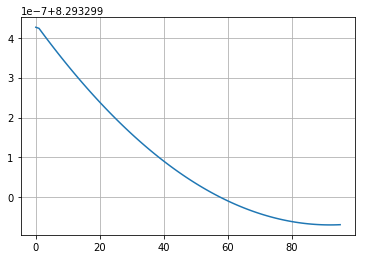

In [29]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[3:])
plt.grid()
plt.show()

##  результаты

In [32]:
O = run(X)
O

array([[0.00025051, 0.00024999],
       [0.00025051, 0.00024999],
       [0.00025051, 0.00024999],
       ...,
       [0.00025051, 0.00024999],
       [0.00025051, 0.00024999],
       [0.00025051, 0.00024999]])

In [30]:
r=np.argmax(O,axis=1).astype(bool)

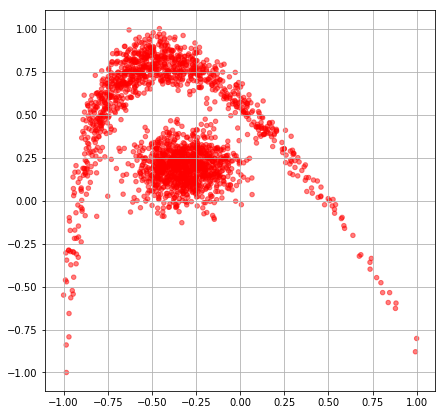

In [34]:
plt.figure(figsize=(7,7))
plt.scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j) else 'r' for j in r ], 
             s=20,
             alpha=0.5 )
plt.grid()
plt.show()